# Descriptive and Predictive Analytics Group Project

## Import Required Libraries

In [1]:
import sys

from pandas                 import DataFrame
from pandas                 import read_csv
from numpy                  import array
from numpy                  import random
from sklearn.linear_model   import LogisticRegression
from sklearn.tree           import DecisionTreeClassifier
from sklearn.ensemble       import RandomForestClassifier
from sklearn.ensemble       import GradientBoostingClassifier
from sklearn.svm            import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.metrics        import accuracy_score
from sklearn.metrics        import auc
from sklearn.metrics        import roc_auc_score
from sklearn.metrics        import roc_curve
from matplotlib             import pyplot
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import kds
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_recall_curve

## Import Data

In [2]:
# Export probabilities to file
directory = r"C:/_BigDataCourses/0974 DescriptivePredictiveAnalytics/GroupAssignment/Project data/" 

In [3]:
from ieseg import partition
from ieseg import roc
from ieseg import lift
from ieseg import cumulativeResponse
from ieseg import cumulativeGains

In [4]:
# Import campaigns data
campaign = pd.read_csv(directory + "campaigns.csv", sep=';')

# Import donors data
donor = pd.read_csv(directory + "donors.csv")

# Import gifts data
gift = pd.read_csv(directory + "gifts.csv")

# Import selection campaign 6169 data
selection_campaign6169 = pd.read_csv(directory + "selection campaign 6169.csv")

# Import selection campaign 7244 data
selection_campaign7244 = pd.read_csv(directory + "selection campaign 7244.csv")

# Import selection campaign 7362 data
selection_campaign7362 = pd.read_csv(directory + "selection campaign 7362.csv")

## Selection Campaign Data Preparation

### Cleaning 'donorID' column

In [5]:
# Remove 'D' and convert 'donorID' to int64
selection_campaign6169['donorID'] = selection_campaign6169['donorID'].apply(lambda x: x.replace('D', '') if 'D' in x else x).astype('int64', errors='ignore')
selection_campaign7244['donorID'] = selection_campaign7244['donorID'].apply(lambda x: x.replace('D', '') if 'D' in x else x).astype('int64', errors='ignore')
selection_campaign7362['donorID'] = selection_campaign7362['donorID'].apply(lambda x: x.replace('D', '') if 'D' in x else x).astype('int64', errors='ignore')

In [6]:
selection_campaign6169.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34888 entries, 0 to 34887
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   donorID  34888 non-null  int64
dtypes: int64(1)
memory usage: 272.7 KB


In [7]:
selection_campaign7244.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25645 entries, 0 to 25644
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   donorID  25645 non-null  int64
dtypes: int64(1)
memory usage: 200.5 KB


In [8]:
selection_campaign7362.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26522 entries, 0 to 26521
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   donorID  26522 non-null  int64
dtypes: int64(1)
memory usage: 207.3 KB


## Campaign Data Preparation

In [9]:
# Print first 5 rows of the campaign dataframe
campaign.head()

,campaignID,date,lettersSent,CostUnit
0,153,13/12/2004,6 873,"0,17 €"
1,154,01/01/2005,7 656,"0,30 €"
2,180,18/01/2005,9 933,"0,20 €"
3,433,29/01/2005,7 448,"0,59 €"
4,476,12/02/2005,6 605,"0,51 €"


In [10]:
# Check the compaign size
campaign.shape

(367, 4)

In [11]:
# Check null values and columns types for campaign data
print(campaign.info())
print(campaign.isna().sum().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   campaignID   367 non-null    int64 
 1   date         367 non-null    object
 2   lettersSent  367 non-null    object
 3   CostUnit     367 non-null    object
dtypes: int64(1), object(3)
memory usage: 11.6+ KB
None
0


In [12]:
# Check the number of duplicate rows in campaign table
campaign.duplicated().sum()

0

In [13]:
# Check the number of unique values for each column in campaign table
campaign.nunique()

campaignID     367
date           367
lettersSent    364
CostUnit        57
dtype: int64

In [14]:
# Convert date column to datetime 
campaign['date'] = pd.to_datetime(campaign['date'])

# Remove spaces in the 'lettersSent' column
campaign['lettersSent'] = campaign['lettersSent'].str.replace(r'\s+', '', regex=True).str.replace(' ', '')

# Convert 'lettersSent' column to numeric after cleaning
campaign['lettersSent'] = campaign['lettersSent'].astype('Int64')

# Remove euro symbol and replace comma with period in 'CostUnit' column
campaign['CostUnit'] = campaign['CostUnit'].str.replace('€', '')  
campaign['CostUnit'] = campaign['CostUnit'].str.replace(',', '.')  

# Convert 'CostUnit' to float after cleaning
campaign['CostUnit'] = campaign['CostUnit'].astype(float)

campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   campaignID   367 non-null    int64         
 1   date         367 non-null    datetime64[ns]
 2   lettersSent  367 non-null    Int64         
 3   CostUnit     367 non-null    float64       
dtypes: Int64(1), datetime64[ns](1), float64(1), int64(1)
memory usage: 12.0 KB


C:\Users\Source\AppData\Local\Temp\ipykernel_10276\1739192145.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  campaign['date'] = pd.to_datetime(campaign['date'])


In [15]:
# Add 'TotalCost' column to derive the total cost of each campaign
campaign['TotalCost'] = campaign['lettersSent'] * campaign['CostUnit']

# Extract year, month, and day into separate columns
campaign['Year'] = campaign['date'].dt.year
campaign['Month'] = campaign['date'].dt.month
campaign['Day'] = campaign['date'].dt.day

# Create 'Season' column
campaign['Season'] = campaign['Month'].apply(lambda x: (
    "Winter" if x in [12, 1, 2] else
    "Spring" if x in [3, 4, 5] else
    "Summer" if x in [6, 7, 8] else
    "Fall"
))

# Create 'Quarter' column
campaign['Quarter'] = pd.PeriodIndex(campaign['date'], freq='Q').strftime('Q%q')

campaign.head()

,campaignID,date,lettersSent,CostUnit,TotalCost,Year,Month,Day,Season,Quarter
0,153,2004-12-13,6873,0.17,1168.41,2004,12,13,Winter,Q4
1,154,2005-01-01,7656,0.30,2296.8,2005,1,1,Winter,Q1
2,180,2005-01-18,9933,0.20,1986.6,2005,1,18,Winter,Q1
3,433,2005-01-29,7448,0.59,4394.32,2005,1,29,Winter,Q1
4,476,2005-02-12,6605,0.51,3368.55,2005,2,12,Winter,Q1


In [16]:
print(campaign.shape)
print(campaign.nunique())

(367, 10)
campaignID     367
date           367
lettersSent    364
CostUnit        57
TotalCost      366
Year            16
Month           12
Day             31
Season           4
Quarter          4
dtype: int64


## Donors Data Preparation

In [17]:
# Print first 5 rows of the donor dataframe
donor.head()

,donorID,zipcode,province,region,gender,language,dateOfBirth
0,D100001,1861.0,Flemish Brabant,Flanders,F,NL,12/24/1967
1,D100002,2260.0,Antwerp,Flanders,M,NL,01/14/1952
2,D100003,1780.0,Flemish Brabant,Flanders,M,NL,12/23/1986
3,D100004,1020.0,Brussels,Brussels,F,FR,03/29/1952
4,D100005,1020.0,Brussels,Brussels,F,FR,06/25/1986


In [18]:
# Check the donor size
donor.shape

(44691, 7)

In [19]:
# Check null values and columns types for donor data
print(donor.info())
print(donor.isna().sum().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44691 entries, 0 to 44690
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   donorID      44691 non-null  object 
 1   zipcode      44689 non-null  float64
 2   province     44691 non-null  object 
 3   region       44691 non-null  object 
 4   gender       44659 non-null  object 
 5   language     44691 non-null  object 
 6   dateOfBirth  44691 non-null  object 
dtypes: float64(1), object(6)
memory usage: 2.4+ MB
None
34


In [20]:
# Check the number of unique values for each column in donor table
donor.nunique()

donorID        44691
zipcode         1024
province          13
region             4
gender             2
language           3
dateOfBirth    18406
dtype: int64

### Cleaning 'donorID' column

In [21]:
# Remove 'D' and convert 'donorID' to int64
donor['donorID'] = donor['donorID'].apply(lambda x: x.replace('D', '') if 'D' in x else x).astype('int64', errors='ignore')

### Cleaning 'region' and 'province' columns

In [22]:
# List region unique values
donor['region'].unique()
# Found 'Missing' as value

array(['Flanders', 'Brussels', 'Wallonia', 'Missing'], dtype=object)

In [23]:
# List rows where region is equal to 'Missing'
region_missing = donor[donor['region'] == 'Missing']
region_missing

,donorID,zipcode,province,region,gender,language,dateOfBirth
5019,105020,NaN,Missing,Missing,M,EN,11/09/1966
22100,122101,NaN,Missing,Missing,F,EN,10/31/1975


In [24]:
# List province unique values
donor['province'].unique()
# Found 'Missing' as value and Antwerp and ANTWERP is showed as two different values based of caps in province

array(['Flemish Brabant', 'Antwerp', 'Brussels', 'Walloon Brabant',
       'West Flanders', 'East Flanders', 'Liege', 'Luxembourg', 'Namur',
       'Hainaut', 'Limburg', 'ANTWERP', 'Missing'], dtype=object)

In [25]:
# Replace ANTWERP with Antwerp
donor.replace({'ANTWERP':'Antwerp'},inplace=True)

In [26]:
# List rows where province is equal to 'Missing'
province_missing = donor[donor['province'] == 'Missing']
province_missing
# Found 'Missing' as value
# Notice that same rows have 'Missing' values in region and province

,donorID,zipcode,province,region,gender,language,dateOfBirth
5019,105020,NaN,Missing,Missing,M,EN,11/09/1966
22100,122101,NaN,Missing,Missing,F,EN,10/31/1975


In [27]:
# Print rows where language is equal to 'EN'
donor_en = donor[donor['language'] == 'EN']
donor_en

,donorID,zipcode,province,region,gender,language,dateOfBirth
533,100534,3080.0,Flemish Brabant,Flanders,M,EN,06/07/1982
5019,105020,NaN,Missing,Missing,M,EN,11/09/1966
6634,106635,3080.0,Flemish Brabant,Flanders,F,EN,01/14/1966
22100,122101,NaN,Missing,Missing,F,EN,10/31/1975
26348,126349,3080.0,Flemish Brabant,Flanders,M,EN,06/23/1954
43374,143375,3090.0,Flemish Brabant,Flanders,F,EN,11/07/1962


In [28]:
# Double Check the most frequent region values when language is equal to 'EN'
en_region_count = donor_en['region'].value_counts().sort_values(ascending=False)
print(en_region_count.head())

# Double Check the most frequent province values when language is equal to 'EN'
en_province_count = donor_en['province'].value_counts().sort_values(ascending=False)
print(en_province_count.head())

region
Flanders    4
Missing     2
Name: count, dtype: int64
province
Flemish Brabant    4
Missing            2
Name: count, dtype: int64


In [29]:
#Replace region having 'Missing' value with the most frequent region (which is the only one) when language is equal to 'EN' 
donor["region"] = donor["region"].replace('Missing', 'Flanders')

#Replace province having 'Missing' value with the most frequent province (which is the only one) when language is equal to 'EN' 
donor["province"] = donor["province"].replace('Missing', 'Flemish Brabant')

In [30]:
# Check region unique values after cleaning
donor['region'].unique()

array(['Flanders', 'Brussels', 'Wallonia'], dtype=object)

In [31]:
# Check province unique values after cleaning
donor['province'].unique()

array(['Flemish Brabant', 'Antwerp', 'Brussels', 'Walloon Brabant',
       'West Flanders', 'East Flanders', 'Liege', 'Luxembourg', 'Namur',
       'Hainaut', 'Limburg'], dtype=object)

### Cleaning 'zipcode' column

In [32]:
# List null values per column in donor data
donor.isnull().sum()

donorID         0
zipcode         2
province        0
region          0
gender         32
language        0
dateOfBirth     0
dtype: int64

In [33]:
# List rows where null and 0 values appear in zipcode column
donor[donor['zipcode'].apply(lambda x: any(c.isalpha() for c in str(x)) or x == 0)]

,donorID,zipcode,province,region,gender,language,dateOfBirth
5019,105020,NaN,Flemish Brabant,Flanders,M,EN,11/09/1966
15231,115232,0.0,Walloon Brabant,Wallonia,M,FR,02/06/1932
22100,122101,NaN,Flemish Brabant,Flanders,F,EN,10/31/1975


In [34]:
# Check the most frequent zipcode value when region is equal to 'Wallonia' and province is equal to 'Walloon Brabant'
donor_wallonia = donor[(donor['region'] == 'Wallonia') & (donor['province'] == 'Walloon Brabant')]
wallonia_zipcode_count = donor_wallonia['zipcode'].value_counts().sort_values(ascending=False)
wallonia_zipcode_count.head()

zipcode
1410.0    51
1400.0    33
1300.0    32
1380.0    30
1420.0    27
Name: count, dtype: int64

In [35]:
#Replace zipcode having 0 value with the most frequent zipcode when region is equal to 'Wallonia' and province is equal to 'Walloon Brabant'
donor['zipcode'] = donor['zipcode'].replace({0: 1410}, regex=False)

In [36]:
# Check the most frequent zipcode value when region is equal to 'Flanders' and province is equal to 'Flemish Brabant'
donor_flanders = donor[(donor['region'] == 'Flanders') & (donor['province'] == 'Flemish Brabant')]
flanders_zipcode_count = donor_flanders['zipcode'].value_counts().sort_values(ascending=False)
flanders_zipcode_count.head()

zipcode
3000.0    284
3001.0    254
3300.0    217
3010.0    208
3080.0    173
Name: count, dtype: int64

In [37]:
#Replace zipcode having null values with the most frequent zipcode when region is equal to 'Flanders' and province is equal to 'Flemish Brabant'
donor['zipcode'] = donor['zipcode'].fillna(3000)

# Check if there are still rows where missing and 0 values appear in zipcode column after cleaning
donor[donor['zipcode'].apply(lambda x: any(c.isalpha() for c in str(x)) or x == 0)]


,donorID,zipcode,province,region,gender,language,dateOfBirth


In [38]:
# Convert zipcode column type to integer
donor['zipcode'] = donor['zipcode'].astype('int64')
donor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44691 entries, 0 to 44690
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   donorID      44691 non-null  int64 
 1   zipcode      44691 non-null  int64 
 2   province     44691 non-null  object
 3   region       44691 non-null  object
 4   gender       44659 non-null  object
 5   language     44691 non-null  object
 6   dateOfBirth  44691 non-null  object
dtypes: int64(2), object(5)
memory usage: 2.4+ MB


### Cleaning 'gender' column

In [39]:
# Remember that we have 32 null values in gender column
# Replace null values with 'Not Mentioned' in the 'gender' column
donor['gender'] = donor['gender'].fillna('Gender Not Mentioned')

In [40]:
# Check null values per column in donor data after preparation
donor.isnull().sum()

donorID        0
zipcode        0
province       0
region         0
gender         0
language       0
dateOfBirth    0
dtype: int64

### Cleaning 'language' column

In [41]:
# List language unique values
donor['language'].unique()
# No cleaning needed for language column

array(['NL', 'FR', 'EN'], dtype=object)

### Cleaning 'dateOfBirth' column

In [42]:
# Convert 'dateOfBirth' column type to datetime
donor['dateOfBirth'] = pd.to_datetime(donor['dateOfBirth'])
donor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44691 entries, 0 to 44690
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   donorID      44691 non-null  int64         
 1   zipcode      44691 non-null  int64         
 2   province     44691 non-null  object        
 3   region       44691 non-null  object        
 4   gender       44691 non-null  object        
 5   language     44691 non-null  object        
 6   dateOfBirth  44691 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 2.4+ MB


In [43]:
donor.head()

,donorID,zipcode,province,region,gender,language,dateOfBirth
0,100001,1861,Flemish Brabant,Flanders,F,NL,1967-12-24
1,100002,2260,Antwerp,Flanders,M,NL,1952-01-14
2,100003,1780,Flemish Brabant,Flanders,M,NL,1986-12-23
3,100004,1020,Brussels,Brussels,F,FR,1952-03-29
4,100005,1020,Brussels,Brussels,F,FR,1986-06-25


## Feature Engineering for donors table

In [44]:
# Create binary columns for each region
donor['R_is_Flanders'] = (donor['region'] == 'Flanders').astype(int)
donor['R_is_Brussels'] = (donor['region'] == 'Brussels').astype(int)
donor['R_is_Wallonia'] = (donor['region'] == 'Wallonia').astype(int)

In [45]:
# Create binary columns for each province with prefix "P_is_"
provinces = sorted(['Flemish Brabant', 'Antwerp', 'Brussels', 'Walloon Brabant', 'West Flanders',
                    'East Flanders', 'Liege', 'Luxembourg', 'Namur', 'Hainaut', 'Limburg'])

for province in provinces:
    donor[f'P_is_{province.replace(" ", "_")}'] = (donor['province'] == province).astype(int)

In [46]:
# Create binary columns for gender
genders = ['F', 'M', 'Gender Not Mentioned']

for gender in genders:
    donor[f'is_{gender.replace(" ", "_")}'] = (donor['gender'] == gender).astype(int)

In [47]:
# List of unique languages
languages = ['NL', 'FR', 'EN']

# Create binary columns for each language
for lang in languages:
    donor[f'is_{lang}_speaker'] = (donor['language'] == lang).astype(int)

In [48]:
# Create new features for date of birth
donor['year_of_birth'] = donor['dateOfBirth'].dt.year
donor['month_of_birth'] = donor['dateOfBirth'].dt.month
donor['day_of_birth'] = donor['dateOfBirth'].dt.day

# Calculate age based on the current date
donor['age_2018'] = 2018 - donor['year_of_birth']
donor['age_2019'] = 2019 - donor['year_of_birth']
donor['age_2020'] = 2020 - donor['year_of_birth']

donor['age_group_2018'] = (donor['age_2018']) // 10 * 10
donor['age_group_2019'] = (donor['age_2019']) // 10 * 10
donor['age_group_2020'] = (donor['age_2020']) // 10 * 10

In [49]:
# Display the updated dataframe info
donor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44691 entries, 0 to 44690
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   donorID                  44691 non-null  int64         
 1   zipcode                  44691 non-null  int64         
 2   province                 44691 non-null  object        
 3   region                   44691 non-null  object        
 4   gender                   44691 non-null  object        
 5   language                 44691 non-null  object        
 6   dateOfBirth              44691 non-null  datetime64[ns]
 7   R_is_Flanders            44691 non-null  int32         
 8   R_is_Brussels            44691 non-null  int32         
 9   R_is_Wallonia            44691 non-null  int32         
 10  P_is_Antwerp             44691 non-null  int32         
 11  P_is_Brussels            44691 non-null  int32         
 12  P_is_East_Flanders       44691 n

In [50]:
donor.head()

,donorID,zipcode,province,region,gender,language,dateOfBirth,R_is_Flanders,R_is_Brussels,R_is_Wallonia,...,is_EN_speaker,year_of_birth,month_of_birth,day_of_birth,age_2018,age_2019,age_2020,age_group_2018,age_group_2019,age_group_2020
0,100001,1861,Flemish Brabant,Flanders,F,NL,1967-12-24,1,0,0,...,0,1967,12,24,51,52,53,50,50,50
1,100002,2260,Antwerp,Flanders,M,NL,1952-01-14,1,0,0,...,0,1952,1,14,66,67,68,60,60,60
2,100003,1780,Flemish Brabant,Flanders,M,NL,1986-12-23,1,0,0,...,0,1986,12,23,32,33,34,30,30,30
3,100004,1020,Brussels,Brussels,F,FR,1952-03-29,0,1,0,...,0,1952,3,29,66,67,68,60,60,60
4,100005,1020,Brussels,Brussels,F,FR,1986-06-25,0,1,0,...,0,1986,6,25,32,33,34,30,30,30


In [51]:
print(donor.shape)
print(donor.nunique())

(44691, 36)
donorID                    44691
zipcode                     1023
province                      11
region                         3
gender                         3
language                       3
dateOfBirth                18406
R_is_Flanders                  2
R_is_Brussels                  2
R_is_Wallonia                  2
P_is_Antwerp                   2
P_is_Brussels                  2
P_is_East_Flanders             2
P_is_Flemish_Brabant           2
P_is_Hainaut                   2
P_is_Liege                     2
P_is_Limburg                   2
P_is_Luxembourg                2
P_is_Namur                     2
P_is_Walloon_Brabant           2
P_is_West_Flanders             2
is_F                           2
is_M                           2
is_Gender_Not_Mentioned        2
is_NL_speaker                  2
is_FR_speaker                  2
is_EN_speaker                  2
year_of_birth                 80
month_of_birth                12
day_of_birth                  3

## Gifts Data Preparation


In [52]:
# Print first 5 rows of the gift dataframe
gift.head()

,donorID,campaignID,amount,date
0,D100001,NaN,"12,39",23/03/2004
1,D100001,1577.0,"12,39",11/10/2007
2,D100001,1634.0,"6,69",28/12/2007
3,D100001,1778.0,"24,79",14/06/2008
4,D100001,1808.0,"7,44",09/07/2008


In [53]:
# Check the gift size
gift.shape

(216594, 4)

In [54]:
# Check null values and columns types for gift data
print(gift.info())
print(gift.isna().sum().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216594 entries, 0 to 216593
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   donorID     216594 non-null  object 
 1   campaignID  200957 non-null  float64
 2   amount      216594 non-null  object 
 3   date        216594 non-null  object 
dtypes: float64(1), object(3)
memory usage: 6.6+ MB
None
15637


In [55]:
# Check the number of unique values for each column in gift table
gift.nunique()

donorID       44700
campaignID      367
amount         1170
date           6113
dtype: int64

In [56]:
# Check the number of duplicate rows in gift table
gift.duplicated().sum()

2007

In [57]:
#Eliminate duplicated rows
gift = gift.drop_duplicates()

# Check again the number of duplicate rows in gift table
gift.duplicated().sum()


0

### Cleaning 'donerID' column

In [58]:
# Remove 'D' and convert 'donorID' to int64
gift['donorID'] = gift['donorID'].apply(lambda x: x.replace('D', '') if 'D' in x else x).astype('int64', errors='ignore')

### Cleaning 'campaignID' column

In [59]:
# Replace campaignID null values with 0
gift['campaignID'].fillna(0, inplace=True)

# Convert 'campaignID' column type to integer
gift['campaignID'] = gift['campaignID'].astype('int64')
gift.info()

<class 'pandas.core.frame.DataFrame'>
Index: 214587 entries, 0 to 216593
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   donorID     214587 non-null  int64 
 1   campaignID  214587 non-null  int64 
 2   amount      214587 non-null  object
 3   date        214587 non-null  object
dtypes: int64(2), object(2)
memory usage: 8.2+ MB


### Cleaning 'amount' column

In [60]:
# Convert 'amount' to float64 by replacing ',' with '.'
#gift['amount'] = gift['amount'].str.replace(',', '.').astype('float64')
#gift['amount'] = gift['amount'].astype('float64')
gift['amount'] = pd.to_numeric(gift['amount'].str.replace(',', '.'), errors='coerce')

In [61]:
gift.info()
gift.head()

<class 'pandas.core.frame.DataFrame'>
Index: 214587 entries, 0 to 216593
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   donorID     214587 non-null  int64  
 1   campaignID  214587 non-null  int64  
 2   amount      214564 non-null  float64
 3   date        214587 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 8.2+ MB


,donorID,campaignID,amount,date
0,100001,0,12.39,23/03/2004
1,100001,1577,12.39,11/10/2007
2,100001,1634,6.69,28/12/2007
3,100001,1778,24.79,14/06/2008
4,100001,1808,7.44,09/07/2008


### Cleaning 'date' column

In [62]:
# Convert 'date' to datetime
gift['date'] = pd.to_datetime(gift['date'], format='%d/%m/%Y')

gift.info()
gift.head()


<class 'pandas.core.frame.DataFrame'>
Index: 214587 entries, 0 to 216593
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   donorID     214587 non-null  int64         
 1   campaignID  214587 non-null  int64         
 2   amount      214564 non-null  float64       
 3   date        214587 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 8.2 MB


,donorID,campaignID,amount,date
0,100001,0,12.39,2004-03-23
1,100001,1577,12.39,2007-10-11
2,100001,1634,6.69,2007-12-28
3,100001,1778,24.79,2008-06-14
4,100001,1808,7.44,2008-07-09


### Feature Engineering for gifts table

In [63]:
# Extract year, month and day from date column
gift['year_of_donation']=gift['date'].dt.year
gift['month_of_donation']=gift['date'].dt.month
gift['day_of_donation']=gift['date'].dt.day

gift

,donorID,campaignID,amount,date,year_of_donation,month_of_donation,day_of_donation
0,100001,0,12.39,2004-03-23,2004,3,23
1,100001,1577,12.39,2007-10-11,2007,10,11
2,100001,1634,6.69,2007-12-28,2007,12,28
3,100001,1778,24.79,2008-06-14,2008,6,14
4,100001,1808,7.44,2008-07-09,2008,7,9
...,...,...,...,...,...,...,...
216589,265584,6169,300.00,2018-09-23,2018,9,23
216590,281770,6169,30.00,2018-09-08,2018,9,8
216591,317880,6169,157.50,2018-09-12,2018,9,12
216592,480980,6169,36.00,2018-09-12,2018,9,12


### Grouping by 'donorID' to have unique donor IDS values

In [64]:
# Calculate total donation amount per donor
total_donation = gift.groupby('donorID')['amount'].sum().reset_index()
total_donation.rename(columns={'amount': 'total_donation_amount'}, inplace=True)

# Calculate number of donations per donor
nb_of_donation = gift.groupby('donorID')['amount'].count().reset_index()
nb_of_donation.rename(columns={'amount': 'nb_of_donations'}, inplace=True)

# Calculate average donation amount per donor
avg_donation = gift.groupby('donorID')['amount'].mean().reset_index()
avg_donation.rename(columns={'amount': 'average_donation_amount'}, inplace=True)

# Calculate minimum donation amount per donor
min_donation = gift.groupby('donorID')['amount'].min().reset_index()
min_donation.rename(columns={'amount': 'minimum_donation_amount'}, inplace=True)

# Calculate maximum donation amount per donor
max_donation = gift.groupby('donorID')['amount'].max().reset_index()
max_donation.rename(columns={'amount': 'maximum_donation_amount'}, inplace=True)

# Calculate number of campaigns where a doner has donated
nb_of_campaigns = gift.groupby('donorID')['campaignID'].nunique().reset_index()
nb_of_campaigns.rename(columns={'campaignID': 'nb_of_campaigns'}, inplace=True)

# Extract first and last dates of donations per donor
first_last_donation_date = gift.groupby('donorID').agg(first_dt_donation=('date', 'first'), last_dt_donation=('date', 'last'))

first_last_donation_date.rename(columns={'first': 'first_donation_date', 'last': 'last_donation_date'}, inplace=True)

In [65]:
# Merge all created tables
final_gift = pd.merge(total_donation, nb_of_donation, on='donorID', how='left')
final_gift = pd.merge(final_gift, avg_donation, on='donorID', how='left')
final_gift = pd.merge(final_gift, min_donation, on='donorID', how='left')
final_gift = pd.merge(final_gift, max_donation, on='donorID', how='left')
final_gift = pd.merge(final_gift, nb_of_campaigns, on='donorID', how='left')
final_gift = pd.merge(final_gift, first_last_donation_date, on='donorID', how='left')

final_gift.head()


,donorID,total_donation_amount,nb_of_donations,average_donation_amount,minimum_donation_amount,maximum_donation_amount,nb_of_campaigns,first_dt_donation,last_dt_donation
0,100001,178.49,12,14.874167,6.69,30.00,12,2004-03-23,2011-12-30
1,100002,20.00,1,20.000000,20.00,20.00,1,2015-01-10,2015-01-10
2,100003,46.00,12,3.833333,3.00,5.00,12,2017-07-27,2019-06-17
3,100004,716.22,26,27.546923,24.79,49.58,26,2005-07-02,2011-06-03
4,100005,24.96,5,4.992000,2.48,10.00,5,2006-10-07,2019-04-18


In [66]:
print(final_gift.shape)
print(final_gift.nunique())

(44700, 9)
donorID                    44700
total_donation_amount       9476
nb_of_donations              126
average_donation_amount    11285
minimum_donation_amount      514
maximum_donation_amount      652
nb_of_campaigns               93
first_dt_donation           3813
last_dt_donation            4713
dtype: int64


In [67]:
are_equal = final_gift['nb_of_donations'].equals(final_gift['nb_of_campaigns'])

if are_equal:
    print("nb_of_donations and nb_of_campaigns have the same exact values.")
else:
    print("nb_of_donations and nb_of_campaigns have different values.")
# Since those 2 columns have different values than we can conclude that some donors have donated multiple times in the same campaign

nb_of_donations and nb_of_campaigns have different values.


In [68]:
# Create a boolean mask to identify rows with different values in nb_of_donations and nb_of_campaigns
mask_different_values = final_gift['nb_of_donations'] != final_gift['nb_of_campaigns']

# Display rows where nb_of_donations and nb_of_campaigns have different values
rows_with_different_values = final_gift[mask_different_values]
rows_with_different_values

,donorID,total_donation_amount,nb_of_donations,average_donation_amount,minimum_donation_amount,maximum_donation_amount,nb_of_campaigns,first_dt_donation,last_dt_donation
53,100054,663.950,15,44.263333,24.79,75.000,14,2007-08-05,2011-10-18
57,100058,333.690,24,13.903750,4.96,49.580,22,2004-05-18,2008-11-29
100,100101,353.530,13,27.194615,24.79,30.000,12,2005-01-24,2012-07-08
109,100110,74.370,3,24.790000,24.79,24.790,1,2001-05-21,2003-05-11
155,100156,177.560,11,16.141818,7.44,40.000,10,2005-11-15,2019-06-02
...,...,...,...,...,...,...,...,...,...
44579,144585,30.000,5,6.000000,6.00,6.000,1,2011-06-17,2011-07-03
44601,144607,2087.890,54,38.664630,12.39,74.370,52,2005-11-12,2011-08-23
44617,144623,50.607,5,10.121400,6.50,16.107,6,2007-06-08,2019-05-16
44642,144648,847.060,30,28.235333,24.79,40.000,29,2000-10-17,2019-10-04


## Creating the general basetable 


In [69]:
general_basetable = pd.merge(donor, final_gift, how = 'left' ,on = 'donorID')
general_basetable

,donorID,zipcode,province,region,gender,language,dateOfBirth,R_is_Flanders,R_is_Brussels,R_is_Wallonia,...,age_group_2019,age_group_2020,total_donation_amount,nb_of_donations,average_donation_amount,minimum_donation_amount,maximum_donation_amount,nb_of_campaigns,first_dt_donation,last_dt_donation
0,100001,1861,Flemish Brabant,Flanders,F,NL,1967-12-24,1,0,0,...,50,50,178.49,12.0,14.874167,6.69,30.00,12.0,2004-03-23,2011-12-30
1,100002,2260,Antwerp,Flanders,M,NL,1952-01-14,1,0,0,...,60,60,20.00,1.0,20.000000,20.00,20.00,1.0,2015-01-10,2015-01-10
2,100003,1780,Flemish Brabant,Flanders,M,NL,1986-12-23,1,0,0,...,30,30,46.00,12.0,3.833333,3.00,5.00,12.0,2017-07-27,2019-06-17
3,100004,1020,Brussels,Brussels,F,FR,1952-03-29,0,1,0,...,60,60,716.22,26.0,27.546923,24.79,49.58,26.0,2005-07-02,2011-06-03
4,100005,1020,Brussels,Brussels,F,FR,1986-06-25,0,1,0,...,30,30,24.96,5.0,4.992000,2.48,10.00,5.0,2006-10-07,2019-04-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44686,144687,4900,Liege,Wallonia,M,FR,1970-09-12,0,0,1,...,40,50,10.00,1.0,10.000000,10.00,10.00,1.0,2015-11-06,2015-11-06
44687,144688,3600,Limburg,Flanders,M,NL,1972-11-28,1,0,0,...,40,40,48.56,7.0,6.937143,2.48,15.00,7.0,2008-03-07,2017-07-27
44688,144689,3061,Flemish Brabant,Flanders,M,NL,1967-04-21,1,0,0,...,50,50,424.79,4.0,106.197500,24.79,200.00,4.0,2005-07-22,2019-12-06
44689,144690,1950,Flemish Brabant,Flanders,M,FR,1976-05-07,1,0,0,...,40,40,40.00,1.0,40.000000,40.00,40.00,1.0,2014-12-30,2014-12-30


In [70]:
print(general_basetable.shape)
print(general_basetable.nunique())

(44691, 44)
donorID                    44691
zipcode                     1023
province                      11
region                         3
gender                         3
language                       3
dateOfBirth                18406
R_is_Flanders                  2
R_is_Brussels                  2
R_is_Wallonia                  2
P_is_Antwerp                   2
P_is_Brussels                  2
P_is_East_Flanders             2
P_is_Flemish_Brabant           2
P_is_Hainaut                   2
P_is_Liege                     2
P_is_Limburg                   2
P_is_Luxembourg                2
P_is_Namur                     2
P_is_Walloon_Brabant           2
P_is_West_Flanders             2
is_F                           2
is_M                           2
is_Gender_Not_Mentioned        2
is_NL_speaker                  2
is_FR_speaker                  2
is_EN_speaker                  2
year_of_birth                 80
month_of_birth                12
day_of_birth                  3

## Creating the train basetable 


In [71]:
final_gift_train = final_gift[(final_gift['last_dt_donation'] > '2013-08-04') & (final_gift['last_dt_donation'] <= '2018-08-04')]

In [72]:
train_basetable = pd.merge(donor, final_gift_train, how = 'left' ,on = 'donorID')
train_basetable = pd.merge(train_basetable, selection_campaign6169, how = 'inner' ,on = 'donorID')
train_basetable

,donorID,zipcode,province,region,gender,language,dateOfBirth,R_is_Flanders,R_is_Brussels,R_is_Wallonia,...,age_group_2019,age_group_2020,total_donation_amount,nb_of_donations,average_donation_amount,minimum_donation_amount,maximum_donation_amount,nb_of_campaigns,first_dt_donation,last_dt_donation
0,100001,1861,Flemish Brabant,Flanders,F,NL,1967-12-24,1,0,0,...,50,50,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
1,100002,2260,Antwerp,Flanders,M,NL,1952-01-14,1,0,0,...,60,60,20.0,1.0,20.0,20.0,20.0,1.0,2015-01-10,2015-01-10
2,100004,1020,Brussels,Brussels,F,FR,1952-03-29,0,1,0,...,60,60,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
3,100008,1780,Flemish Brabant,Flanders,M,FR,1937-08-30,1,0,0,...,80,80,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
4,100009,1020,Brussels,Brussels,M,FR,1932-01-20,0,1,0,...,80,80,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34869,144686,2440,Antwerp,Flanders,F,NL,1964-09-28,1,0,0,...,50,50,50.0,1.0,50.0,50.0,50.0,1.0,2015-04-28,2015-04-28
34870,144687,4900,Liege,Wallonia,M,FR,1970-09-12,0,0,1,...,40,50,10.0,1.0,10.0,10.0,10.0,1.0,2015-11-06,2015-11-06
34871,144689,3061,Flemish Brabant,Flanders,M,NL,1967-04-21,1,0,0,...,50,50,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
34872,144690,1950,Flemish Brabant,Flanders,M,FR,1976-05-07,1,0,0,...,40,40,40.0,1.0,40.0,40.0,40.0,1.0,2014-12-30,2014-12-30


In [73]:
# Drop first_dt_donation and last_dt_donation date as we have filtered the dataset
# Not reauired anymore
train_basetable.drop(columns=['province','region','province','gender','language','dateOfBirth','first_dt_donation', 'last_dt_donation'], inplace=True)

In [74]:
# Fill NaN values with zeros
train_basetable.fillna(0, inplace=True)

In [75]:
# Convert specified columns to integers
columns_to_convert = ['total_donation_amount', 'nb_of_donations', 'average_donation_amount',
                       'minimum_donation_amount', 'maximum_donation_amount', 'nb_of_campaigns']

train_basetable[columns_to_convert] = general_basetable[columns_to_convert].fillna(0).round().astype('int64')

In [76]:
print(train_basetable.shape)
print(train_basetable.nunique())

(34874, 37)
donorID                    34874
zipcode                      962
R_is_Flanders                  2
R_is_Brussels                  2
R_is_Wallonia                  2
P_is_Antwerp                   2
P_is_Brussels                  2
P_is_East_Flanders             2
P_is_Flemish_Brabant           2
P_is_Hainaut                   2
P_is_Liege                     2
P_is_Limburg                   2
P_is_Luxembourg                2
P_is_Namur                     2
P_is_Walloon_Brabant           2
P_is_West_Flanders             2
is_F                           2
is_M                           2
is_Gender_Not_Mentioned        2
is_NL_speaker                  2
is_FR_speaker                  2
is_EN_speaker                  2
year_of_birth                 79
month_of_birth                12
day_of_birth                  31
age_2018                      79
age_2019                      79
age_2020                      79
age_group_2018                 9
age_group_2019                1

In [77]:
# Create the target variable for train data: donations >= 30
#train_basetable['top_donor'] = train_basetable['total_donation_amount'] >= 30
train_basetable['top_donor'] = train_basetable['minimum_donation_amount'].apply(lambda x: 1 if x >= 30 else 0)
train_basetable.head(5)

,donorID,zipcode,R_is_Flanders,R_is_Brussels,R_is_Wallonia,P_is_Antwerp,P_is_Brussels,P_is_East_Flanders,P_is_Flemish_Brabant,P_is_Hainaut,...,age_group_2018,age_group_2019,age_group_2020,total_donation_amount,nb_of_donations,average_donation_amount,minimum_donation_amount,maximum_donation_amount,nb_of_campaigns,top_donor
0,100001,1861,1,0,0,0,0,0,1,0,...,50,50,50,178,12,15,7,30,12,0
1,100002,2260,1,0,0,1,0,0,0,0,...,60,60,60,20,1,20,20,20,1,0
2,100004,1020,0,1,0,0,1,0,0,0,...,60,60,60,46,12,4,3,5,12,0
3,100008,1780,1,0,0,0,0,0,1,0,...,80,80,80,716,26,28,25,50,26,0
4,100009,1020,0,1,0,0,1,0,0,0,...,80,80,80,25,5,5,2,10,5,0


## Creating the test basetable 


In [78]:
final_gift_test = final_gift[(final_gift['last_dt_donation'] > '2014-05-18') & (final_gift['last_dt_donation'] <= '2019-05-18')]

In [79]:
test_basetable = pd.merge(donor, final_gift_test, how = 'left' ,on = 'donorID')
test_basetable = pd.merge(test_basetable, selection_campaign7244, how = 'inner' ,on = 'donorID')
test_basetable

,donorID,zipcode,province,region,gender,language,dateOfBirth,R_is_Flanders,R_is_Brussels,R_is_Wallonia,...,age_group_2019,age_group_2020,total_donation_amount,nb_of_donations,average_donation_amount,minimum_donation_amount,maximum_donation_amount,nb_of_campaigns,first_dt_donation,last_dt_donation
0,100001,1861,Flemish Brabant,Flanders,F,NL,1967-12-24,1,0,0,...,50,50,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
1,100002,2260,Antwerp,Flanders,M,NL,1952-01-14,1,0,0,...,60,60,20.0,1.0,20.0,20.0,20.0,1.0,2015-01-10,2015-01-10
2,100008,1780,Flemish Brabant,Flanders,M,FR,1937-08-30,1,0,0,...,80,80,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
3,100009,1020,Brussels,Brussels,M,FR,1932-01-20,0,1,0,...,80,80,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
4,100010,1020,Brussels,Brussels,M,FR,1983-05-30,0,1,0,...,30,30,40.0,1.0,40.0,40.0,40.0,1.0,2015-01-13,2015-01-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25640,144682,1640,Flemish Brabant,Flanders,M,FR,1982-08-29,1,0,0,...,30,30,40.0,1.0,40.0,40.0,40.0,1.0,2016-08-10,2016-08-10
25641,144683,9308,East Flanders,Flanders,Gender Not Mentioned,NL,1985-06-15,1,0,0,...,30,30,50.0,1.0,50.0,50.0,50.0,1.0,2015-10-11,2015-10-11
25642,144686,2440,Antwerp,Flanders,F,NL,1964-09-28,1,0,0,...,50,50,50.0,1.0,50.0,50.0,50.0,1.0,2015-04-28,2015-04-28
25643,144690,1950,Flemish Brabant,Flanders,M,FR,1976-05-07,1,0,0,...,40,40,40.0,1.0,40.0,40.0,40.0,1.0,2014-12-30,2014-12-30


In [80]:
# Drop first_dt_donation and last_dt_donation date as we have filtered the dataset
# Not reauired anymore
test_basetable.drop(columns=['province','region','province','gender','language','dateOfBirth','first_dt_donation', 'last_dt_donation'], inplace=True)

In [81]:
# Fill NaN values with zeros
test_basetable.fillna(0, inplace=True)

In [82]:
# Convert specified columns to integers
columns_to_convert = ['total_donation_amount', 'nb_of_donations', 'average_donation_amount',
                       'minimum_donation_amount', 'maximum_donation_amount', 'nb_of_campaigns']

test_basetable[columns_to_convert] = general_basetable[columns_to_convert].fillna(0).round().astype('int64')

In [83]:
print(test_basetable.shape)
print(test_basetable.nunique())

(25645, 37)
donorID                    25645
zipcode                      939
R_is_Flanders                  2
R_is_Brussels                  2
R_is_Wallonia                  2
P_is_Antwerp                   2
P_is_Brussels                  2
P_is_East_Flanders             2
P_is_Flemish_Brabant           2
P_is_Hainaut                   2
P_is_Liege                     2
P_is_Limburg                   2
P_is_Luxembourg                2
P_is_Namur                     2
P_is_Walloon_Brabant           2
P_is_West_Flanders             2
is_F                           2
is_M                           2
is_Gender_Not_Mentioned        2
is_NL_speaker                  2
is_FR_speaker                  2
is_EN_speaker                  2
year_of_birth                 79
month_of_birth                12
day_of_birth                  31
age_2018                      79
age_2019                      79
age_2020                      79
age_group_2018                 9
age_group_2019                1

In [84]:
# Create the target variable for test data: donations => 30
#test_basetable['top_donor'] = test_basetable['total_donation_amount'] >= 30
test_basetable['top_donor'] = test_basetable['minimum_donation_amount'].apply(lambda x: 1 if x >= 30 else 0)
test_basetable.head(5)

,donorID,zipcode,R_is_Flanders,R_is_Brussels,R_is_Wallonia,P_is_Antwerp,P_is_Brussels,P_is_East_Flanders,P_is_Flemish_Brabant,P_is_Hainaut,...,age_group_2018,age_group_2019,age_group_2020,total_donation_amount,nb_of_donations,average_donation_amount,minimum_donation_amount,maximum_donation_amount,nb_of_campaigns,top_donor
0,100001,1861,1,0,0,0,0,0,1,0,...,50,50,50,178,12,15,7,30,12,0
1,100002,2260,1,0,0,1,0,0,0,0,...,60,60,60,20,1,20,20,20,1,0
2,100008,1780,1,0,0,0,0,0,1,0,...,80,80,80,46,12,4,3,5,12,0
3,100009,1020,0,1,0,0,1,0,0,0,...,80,80,80,716,26,28,25,50,26,0
4,100010,1020,0,1,0,0,1,0,0,0,...,30,30,30,25,5,5,2,10,5,0


## Creating the New basetable 

In [85]:
final_gift_new = final_gift[(final_gift['last_dt_donation'] > '2015-01-01') & (final_gift['last_dt_donation'] <= '2020-01-01')]

In [86]:
new_basetable = pd.merge(donor, final_gift_new, how = 'left' ,on = 'donorID')
new_basetable = pd.merge(new_basetable, selection_campaign7362, how = 'inner' ,on = 'donorID')
new_basetable

,donorID,zipcode,province,region,gender,language,dateOfBirth,R_is_Flanders,R_is_Brussels,R_is_Wallonia,...,age_group_2019,age_group_2020,total_donation_amount,nb_of_donations,average_donation_amount,minimum_donation_amount,maximum_donation_amount,nb_of_campaigns,first_dt_donation,last_dt_donation
0,100001,1861,Flemish Brabant,Flanders,F,NL,1967-12-24,1,0,0,...,50,50,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
1,100003,1780,Flemish Brabant,Flanders,M,NL,1986-12-23,1,0,0,...,30,30,46.00,12.0,3.833333,3.00,5.0,12.0,2017-07-27,2019-06-17
2,100004,1020,Brussels,Brussels,F,FR,1952-03-29,0,1,0,...,60,60,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
3,100006,1090,Brussels,Brussels,M,FR,1926-06-01,0,1,0,...,90,90,5.00,1.0,5.000000,5.00,5.0,1.0,2017-08-15,2017-08-15
4,100009,1020,Brussels,Brussels,M,FR,1932-01-20,0,1,0,...,80,80,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26506,144687,4900,Liege,Wallonia,M,FR,1970-09-12,0,0,1,...,40,50,10.00,1.0,10.000000,10.00,10.0,1.0,2015-11-06,2015-11-06
26507,144688,3600,Limburg,Flanders,M,NL,1972-11-28,1,0,0,...,40,40,48.56,7.0,6.937143,2.48,15.0,7.0,2008-03-07,2017-07-27
26508,144689,3061,Flemish Brabant,Flanders,M,NL,1967-04-21,1,0,0,...,50,50,424.79,4.0,106.197500,24.79,200.0,4.0,2005-07-22,2019-12-06
26509,144690,1950,Flemish Brabant,Flanders,M,FR,1976-05-07,1,0,0,...,40,40,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT


In [87]:
# Drop first_dt_donation and last_dt_donation date as we have filtered the dataset
# Not reauired anymore
new_basetable.drop(columns=['province','region','province','gender','language','dateOfBirth','first_dt_donation', 'last_dt_donation'], inplace=True)

In [88]:
# Fill NaN values with zeros
new_basetable.fillna(0, inplace=True)

In [89]:
# Convert specified columns to integers
columns_to_convert = ['total_donation_amount', 'nb_of_donations', 'average_donation_amount',
                       'minimum_donation_amount', 'maximum_donation_amount', 'nb_of_campaigns']

new_basetable[columns_to_convert] = general_basetable[columns_to_convert].fillna(0).round().astype('int64')

In [90]:
print(new_basetable.shape)
print(new_basetable.nunique())

(26511, 37)
donorID                    26511
zipcode                      971
R_is_Flanders                  2
R_is_Brussels                  2
R_is_Wallonia                  2
P_is_Antwerp                   2
P_is_Brussels                  2
P_is_East_Flanders             2
P_is_Flemish_Brabant           2
P_is_Hainaut                   2
P_is_Liege                     2
P_is_Limburg                   2
P_is_Luxembourg                2
P_is_Namur                     2
P_is_Walloon_Brabant           2
P_is_West_Flanders             2
is_F                           2
is_M                           2
is_Gender_Not_Mentioned        2
is_NL_speaker                  2
is_FR_speaker                  2
is_EN_speaker                  2
year_of_birth                 79
month_of_birth                12
day_of_birth                  31
age_2018                      79
age_2019                      79
age_2020                      79
age_group_2018                 9
age_group_2019                1

In [91]:
new_basetable.head()

,donorID,zipcode,R_is_Flanders,R_is_Brussels,R_is_Wallonia,P_is_Antwerp,P_is_Brussels,P_is_East_Flanders,P_is_Flemish_Brabant,P_is_Hainaut,...,age_2020,age_group_2018,age_group_2019,age_group_2020,total_donation_amount,nb_of_donations,average_donation_amount,minimum_donation_amount,maximum_donation_amount,nb_of_campaigns
0,100001,1861,1,0,0,0,0,0,1,0,...,53,50,50,50,178,12,15,7,30,12
1,100003,1780,1,0,0,0,0,0,1,0,...,34,30,30,30,20,1,20,20,20,1
2,100004,1020,0,1,0,0,1,0,0,0,...,68,60,60,60,46,12,4,3,5,12
3,100006,1090,0,1,0,0,1,0,0,0,...,94,90,90,90,716,26,28,25,50,26
4,100009,1020,0,1,0,0,1,0,0,0,...,88,80,80,80,25,5,5,2,10,5


In [92]:
# Create the target variable for test data: donations => 30
#test_basetable['top_donor'] = test_basetable['total_donation_amount'] >= 30
new_basetable['top_donor'] = new_basetable['minimum_donation_amount'].apply(lambda x: 1 if x >= 30 else 0)
new_basetable.head(5)

,donorID,zipcode,R_is_Flanders,R_is_Brussels,R_is_Wallonia,P_is_Antwerp,P_is_Brussels,P_is_East_Flanders,P_is_Flemish_Brabant,P_is_Hainaut,...,age_group_2018,age_group_2019,age_group_2020,total_donation_amount,nb_of_donations,average_donation_amount,minimum_donation_amount,maximum_donation_amount,nb_of_campaigns,top_donor
0,100001,1861,1,0,0,0,0,0,1,0,...,50,50,50,178,12,15,7,30,12,0
1,100003,1780,1,0,0,0,0,0,1,0,...,30,30,30,20,1,20,20,20,1,0
2,100004,1020,0,1,0,0,1,0,0,0,...,60,60,60,46,12,4,3,5,12,0
3,100006,1090,0,1,0,0,1,0,0,0,...,90,90,90,716,26,28,25,50,26,0
4,100009,1020,0,1,0,0,1,0,0,0,...,80,80,80,25,5,5,2,10,5,0


In [93]:
len(new_basetable[new_basetable['top_donor'] == 1])

5651

## Pearson Correlation Coefficient - Feature selection

In [94]:
selectedFeatures = []
target = "top_donor"

for column in train_basetable.columns:
    if column not in ('donorID', 'zipcode', target):
        (pearson, pvalue) = pearsonr(train_basetable[column], train_basetable[target])
        print(f"{column} - p-value = {pvalue} - selected: {1 if pvalue < 0.05 else 0}")
        if pvalue < 0.05:
            selectedFeatures.append(column)

R_is_Flanders - p-value = 0.0007487445247990388 - selected: 1
R_is_Brussels - p-value = 0.07822485572326729 - selected: 0
R_is_Wallonia - p-value = 0.004906824514117104 - selected: 1
P_is_Antwerp - p-value = 0.40300885702897504 - selected: 0
P_is_Brussels - p-value = 0.07822485572326729 - selected: 0
P_is_East_Flanders - p-value = 0.005227271599389998 - selected: 1
P_is_Flemish_Brabant - p-value = 0.1806437135702382 - selected: 0
P_is_Hainaut - p-value = 0.04014161014024951 - selected: 1
P_is_Liege - p-value = 0.36627745825483066 - selected: 0
P_is_Limburg - p-value = 0.04481411699752091 - selected: 1
P_is_Luxembourg - p-value = 0.774743861268306 - selected: 0
P_is_Namur - p-value = 0.33683813221042896 - selected: 0
P_is_Walloon_Brabant - p-value = 0.027498385468832345 - selected: 1
P_is_West_Flanders - p-value = 0.2962014802165776 - selected: 0
is_F - p-value = 0.7580182302601973 - selected: 0
is_M - p-value = 0.837797351141195 - selected: 0
is_Gender_Not_Mentioned - p-value = 0.03396

In [95]:
#following features have a sufficient pearson correlation
selectedFeatures

['R_is_Flanders',
 'R_is_Wallonia',
 'P_is_East_Flanders',
 'P_is_Hainaut',
 'P_is_Limburg',
 'P_is_Walloon_Brabant',
 'is_Gender_Not_Mentioned',
 'is_NL_speaker',
 'is_FR_speaker',
 'year_of_birth',
 'age_2018',
 'age_2019',
 'age_2020',
 'age_group_2018',
 'age_group_2020',
 'total_donation_amount',
 'nb_of_donations',
 'average_donation_amount',
 'maximum_donation_amount',
 'nb_of_campaigns']

In [96]:
model = LogisticRegression(solver = "lbfgs", max_iter = 800,class_weight='balanced')

In [97]:
model.fit(train_basetable[selectedFeatures], train_basetable[target])

LogisticRegression(class_weight='balanced', max_iter=800)

In [98]:
DataFrame(model.predict_proba(train_basetable[selectedFeatures]))[1]

0        0.001106
1        0.088521
2        0.000171
3        0.007833
4        0.000346
           ...   
34869    0.999115
34870    0.106506
34871    0.000468
34872    0.253317
34873    0.003666
Name: 1, Length: 34874, dtype: float64

In [99]:
train_basetable["predicted_donor"] = DataFrame(model.predict_proba(train_basetable[selectedFeatures]))[1]
test_basetable["predicted_donor"]     = DataFrame(model.predict_proba(test_basetable[selectedFeatures]))[1]

In [100]:
aucTraining = roc_auc_score(array(train_basetable[target]),array(train_basetable["predicted_donor"]))
aucTest     = roc_auc_score(array(test_basetable[target]),array(test_basetable["predicted_donor"]))

print(aucTraining)
print(aucTest)

0.9642313243864346
0.958740424441339


## Stepwise Regression - Feature selection

In [101]:
def stepwiseRegresion (trainingSet: DataFrame, testSet: DataFrame, selectedFeatures: [str], target: [str]) -> DataFrame:

    def computeAUC (forFeatures: [str]) -> ([str],float,float):
    
        model.fit(trainingSet[forFeatures], trainingSet[target])

        trainingSet["predicted_donor"] = DataFrame(model.predict_proba(trainingSet[forFeatures]))[1]
        testSet["predicted_donor"]     = DataFrame(model.predict_proba(testSet[forFeatures]))[1]

        aucTraining = roc_auc_score(array(trainingSet[target]),array(trainingSet["predicted_donor"]))
        aucTest     = roc_auc_score(array(testSet[target]),array(testSet["predicted_donor"]))

        trainingSet.drop("predicted_donor", axis = 1)
        testSet.drop("predicted_donor", axis = 1)

        return (forFeatures,aucTraining,aucTest)

    featuresOrder = []
    forwardSelection = []

    for step in range(len(selectedFeatures)):
        print(f"step {step+1}")
        aucs = []
        for feature in selectedFeatures:
            if feature not in featuresOrder:
                modelFeatures = featuresOrder.copy()
                modelFeatures.append(feature)
                aucs.append(computeAUC(forFeatures = modelFeatures))

        steps = DataFrame(aucs)
        steps.columns = ["Feature","AUC training", "AUC test"]
        steps = steps.sort_values(by=["AUC test"], ascending = False)

        featuresOrder = steps["Feature"].iloc[0]
        forwardSelection.append((step+1, steps["Feature"].iloc[0],steps["AUC training"].iloc[0],steps["AUC test"].iloc[0]))

    df = DataFrame(forwardSelection)
    df.columns = ("Step","Features","AUC Train","AUC Test")
    
    return df

In [102]:
forwardSelection = stepwiseRegresion(trainingSet      = train_basetable, 
                                     testSet          = test_basetable, 
                                     selectedFeatures = selectedFeatures,
                                     target           = target)

step 1
step 2
step 3
step 4
step 5
step 6
step 7
step 8
step 9
step 10
step 11
step 12
step 13
step 14
step 15
step 16
step 17
step 18
step 19
step 20


In [103]:
forwardSelection.head()

,Step,Features,AUC Train,AUC Test
0,1,[average_donation_amount],0.925015,0.924718
1,2,"[average_donation_amount, maximum_donation_amo...",0.961845,0.957700
2,3,"[average_donation_amount, maximum_donation_amo...",0.964063,0.959126
3,4,"[average_donation_amount, maximum_donation_amo...",0.964075,0.959161
4,5,"[average_donation_amount, maximum_donation_amo...",0.964058,0.959176


In [104]:
selectedFeatures

['R_is_Flanders',
 'R_is_Wallonia',
 'P_is_East_Flanders',
 'P_is_Hainaut',
 'P_is_Limburg',
 'P_is_Walloon_Brabant',
 'is_Gender_Not_Mentioned',
 'is_NL_speaker',
 'is_FR_speaker',
 'year_of_birth',
 'age_2018',
 'age_2019',
 'age_2020',
 'age_group_2018',
 'age_group_2020',
 'total_donation_amount',
 'nb_of_donations',
 'average_donation_amount',
 'maximum_donation_amount',
 'nb_of_campaigns']

## Train Model

In [105]:
# Initiate the models 
tree         = DecisionTreeClassifier(class_weight='balanced')
logistic     = LogisticRegression(solver = "lbfgs", max_iter = 800,class_weight='balanced')
randomForest = RandomForestClassifier(n_estimators = 100,class_weight='balanced')
boostedTree  = GradientBoostingClassifier()
svm          = SVC(gamma = "scale", probability = True,class_weight='balanced')
neuralNet    = MLPClassifier()
neighbors    = KNeighborsClassifier()

In [106]:
models = {"tree"         :tree,
          "logistic"     :logistic,
          "randomForest" :randomForest,
          "boostedTree"  :boostedTree,
          #"svm"          :svm,
          "neuralNet"    :neuralNet
         }

In [107]:
# Train the models for the training set
for model in models:
    models[model].fit(train_basetable[selectedFeatures],train_basetable[target])
    print(f"{model} has been trained successfully")

tree has been trained successfully
logistic has been trained successfully
randomForest has been trained successfully
boostedTree has been trained successfully
neuralNet has been trained successfully


## Compute the AUC and Accuracy for each model

In [108]:
performances = {}

for model in models:
    predictions   = models[model].predict(test_basetable[selectedFeatures])
    probabilities = DataFrame(models[model].predict_proba(test_basetable[selectedFeatures]))[1]
    accuracy      = accuracy_score(test_basetable[target],predictions)
    auc           = roc_auc_score(array(test_basetable[target]),array(probabilities))
    
    performances[model] = {"Accuracy":accuracy,"AUC":auc}

In [109]:
DataFrame(performances)

,tree,logistic,randomForest,boostedTree,neuralNet
Accuracy,0.963307,0.912654,0.952700,0.953402,0.895262
AUC,0.948441,0.958740,0.990342,0.991316,0.975439


## Confusion Matrix

99.97992773986351
96.35016572431273


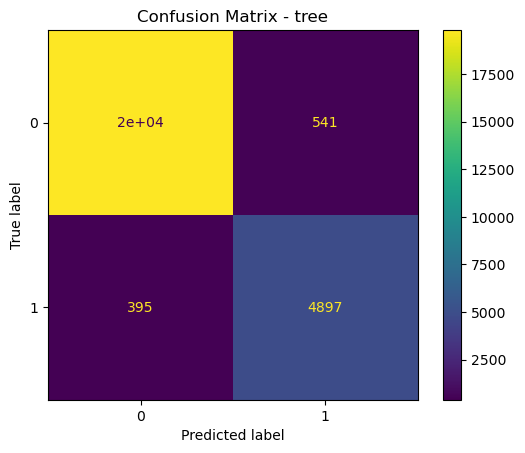

92.59620347536847
91.26535387015012


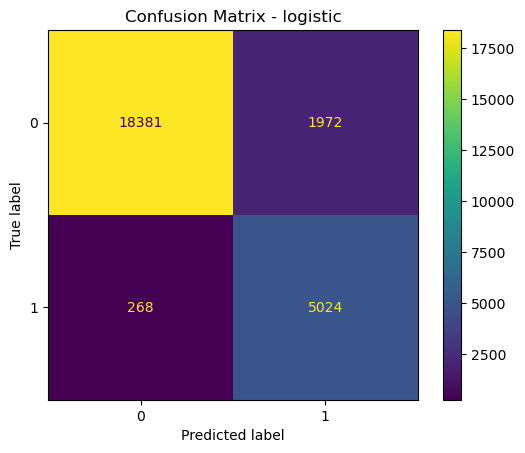

99.97992773986351
95.17254825502047


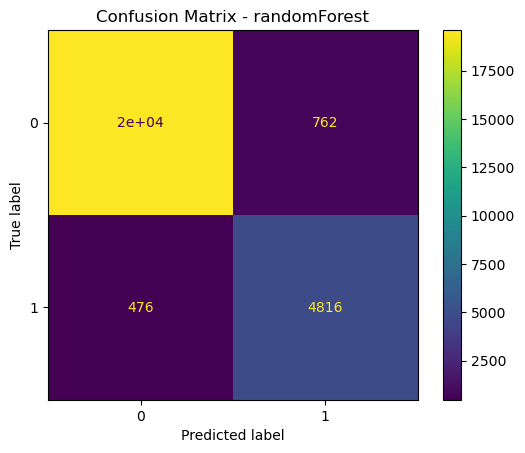

95.58697023570568
95.34022226554883


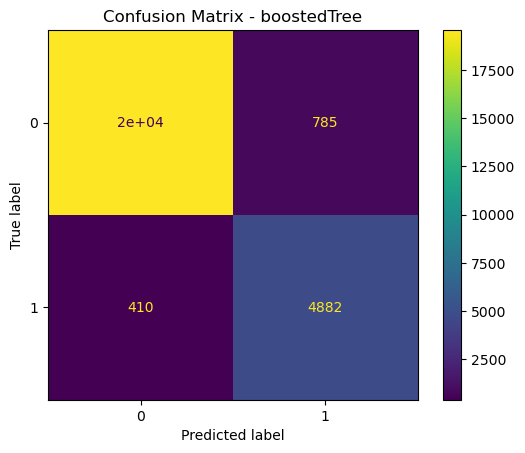

93.66576819407008
92.71202963540651


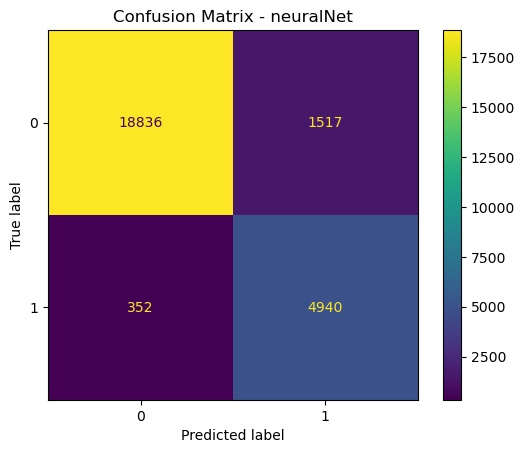

In [110]:
for model_name, model in models.items():
    model.fit(train_basetable[selectedFeatures],train_basetable[target])
    
    train_basetable["predicted_donor"] = DataFrame(model.predict(train_basetable[selectedFeatures]))
    test_basetable["predicted_donor"] = DataFrame(model.predict(test_basetable[selectedFeatures]))
    #calculate accuracy of train_basetable
    print(accuracy_score(train_basetable['top_donor'],train_basetable['predicted_donor'])*100)
    #calculate accuracy of testset
    print(accuracy_score(test_basetable['top_donor'],test_basetable['predicted_donor'])*100)
    #plot a confusion matrix from the test set
    cm = confusion_matrix(test_basetable['top_donor'], test_basetable['predicted_donor'], labels=model.classes_)
    color = 'white'
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    pyplot.title(f'Confusion Matrix - {model_name}')
    pyplot.show()

## ROC curve and AUC score

AUC Score for tree 0.95
AUC Score for logistic 0.96
AUC Score for randomForest 0.99
AUC Score for boostedTree 0.99
AUC Score for neuralNet 0.99


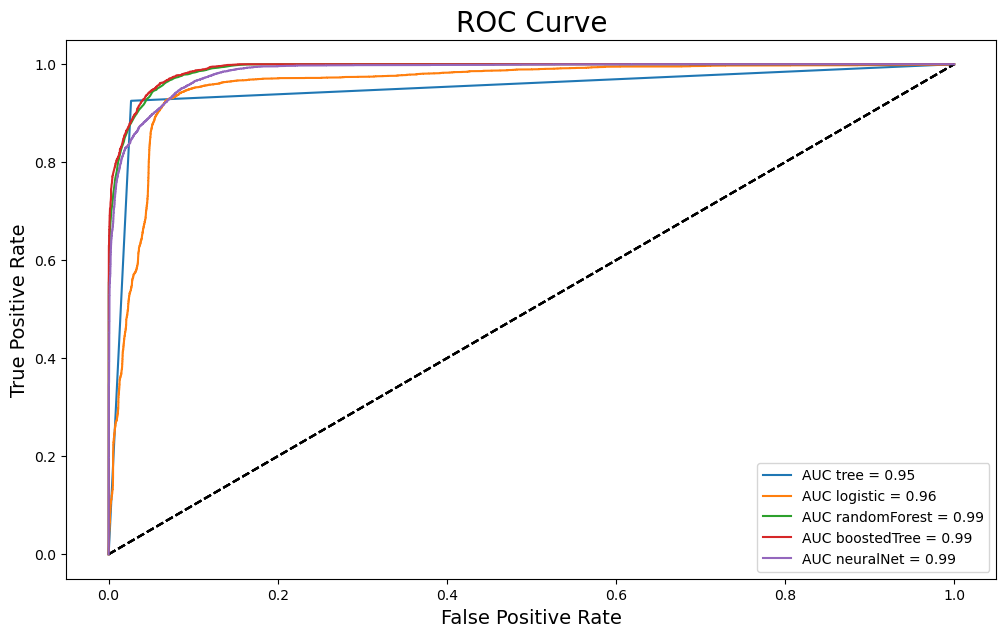

In [111]:
X_train = train_basetable[selectedFeatures]
y_train = train_basetable[target]
X_test = test_basetable[selectedFeatures]
Y_test = test_basetable[target]

plt.figure(figsize=(12, 7))
for model in models:
    x =  models[model].predict_proba(X_test)[:, 1]
    y = roc_auc_score(Y_test, x)
    fpr, tpr, thresholds = roc_curve(Y_test, x)
    print('AUC Score for', model, round(y,2)) 
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=f'AUC {model} = {y:.2f}')
    plt.title('ROC Curve', size=20)
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend()

## Lift curve, Cumulative Response and Cumulative Gains

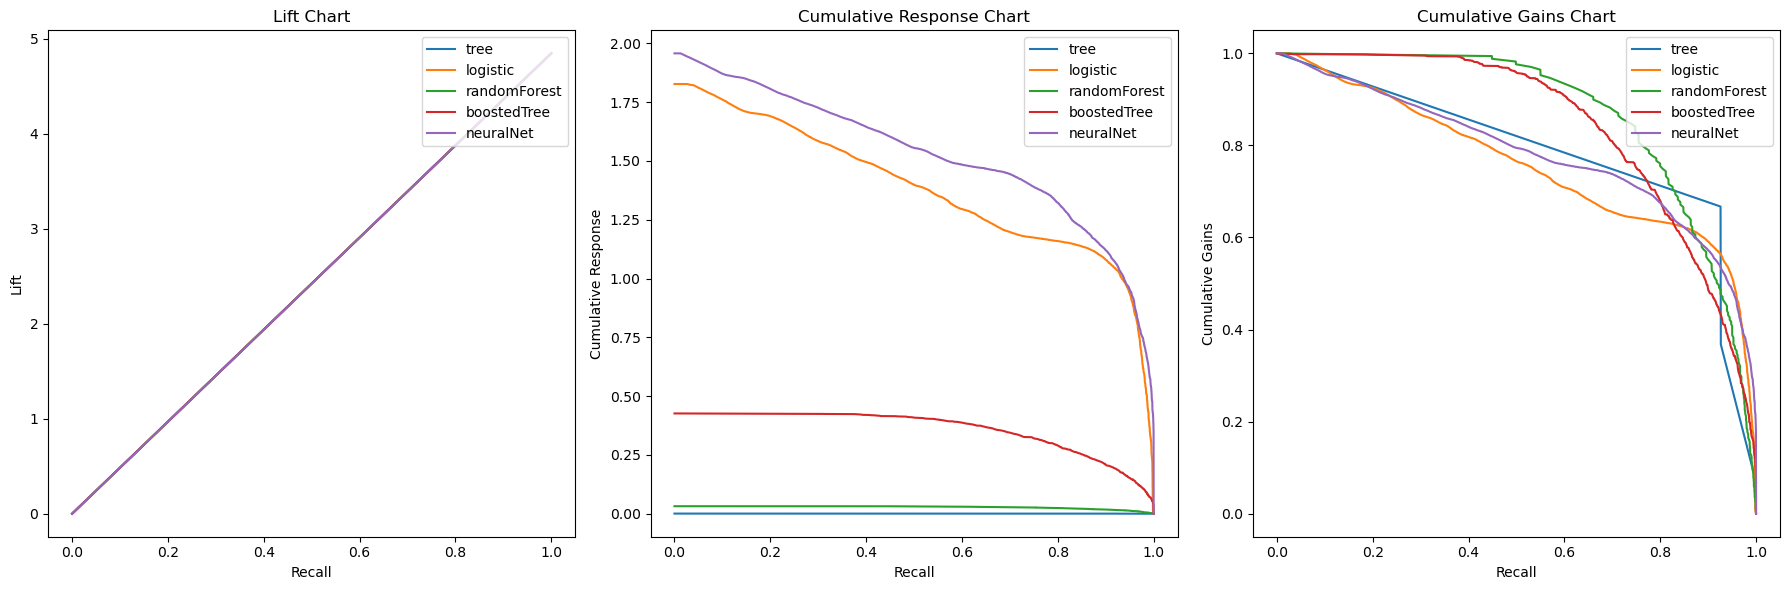

In [112]:
def plot_lift_chart(y_test, y_score, model_name):
    precision, recall, _ = precision_recall_curve(y_test.ravel(), y_score.ravel())
    lift = recall / (np.sum(y_test) / len(y_test))

    plt.plot(recall, lift, label=f'{model_name}')

def plot_cumulative_response_chart(y_test, y_score, model_name):
    precision, recall, _ = precision_recall_curve(y_test.ravel(), y_score.ravel())
    cumulative_response = np.cumsum(precision) / np.sum(y_test)

    plt.plot(recall, cumulative_response, label=f'{model_name}')

def plot_cumulative_gains_chart(y_test, y_score, model_name):
    precision, recall, _ = precision_recall_curve(y_test.ravel(), y_score.ravel())
    cumulative_gain = np.cumsum(precision) / np.sum(precision)

    plt.plot(recall, cumulative_gain, label=f'{model_name}')

# Split the data into training and test sets
X_train = train_basetable[selectedFeatures]
y_train = train_basetable[target]
X_test = test_basetable[selectedFeatures]
y_test = test_basetable[target]

# Create a figure and axis for Lift, Cumulative Response, and Cumulative Gains charts
plt.figure(figsize=(18, 6))

# Iterate through models
for model_name, model in models.items():
    # Binarize the target variable
    y_bin = label_binarize(y_test, classes=[0, 1])  # Assuming 0 and 1 are the class labels

    # Create a OneVsRestClassifier for models that don't support multi-class directly
    if not hasattr(model, "decision_function"):
        model = OneVsRestClassifier(model)

    # Fit the model and get predicted probabilities
    if hasattr(model, "predict_proba"):
        y_score = model.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    else:
        y_score = model.fit(X_train, y_train).decision_function(X_test)

    # Plot the Lift chart
    plt.subplot(1, 3, 1)
    plot_lift_chart(y_bin, y_score, model_name)

    # Plot the Cumulative Response chart
    plt.subplot(1, 3, 2)
    plot_cumulative_response_chart(y_bin, y_score, model_name)

    # Plot the Cumulative Gains chart
    plt.subplot(1, 3, 3)
    plot_cumulative_gains_chart(y_bin, y_score, model_name)

# Set labels and titles for Lift chart
plt.subplot(1, 3, 1)
plt.xlabel('Recall')
plt.ylabel('Lift')
plt.title('Lift Chart')
plt.legend(loc="upper right")

# Set labels and titles for Cumulative Response chart
plt.subplot(1, 3, 2)
plt.xlabel('Recall')
plt.ylabel('Cumulative Response')
plt.title('Cumulative Response Chart')
plt.legend(loc="upper right")

# Set labels and titles for Cumulative Gains chart
plt.subplot(1, 3, 3)
plt.xlabel('Recall')
plt.ylabel('Cumulative Gains')
plt.title('Cumulative Gains Chart')
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()


## Model Usage

In [113]:
donor_basetable = new_basetable.copy()
donor_basetable['probability'] = pd.DataFrame(logistic.predict_proba(donor_basetable[selectedFeatures]))[1]
donor_basetable['top_donor'] = pd.DataFrame(logistic.predict(donor_basetable[selectedFeatures]))
donor_basetable

,donorID,zipcode,R_is_Flanders,R_is_Brussels,R_is_Wallonia,P_is_Antwerp,P_is_Brussels,P_is_East_Flanders,P_is_Flemish_Brabant,P_is_Hainaut,...,age_group_2019,age_group_2020,total_donation_amount,nb_of_donations,average_donation_amount,minimum_donation_amount,maximum_donation_amount,nb_of_campaigns,top_donor,probability
0,100001,1861,1,0,0,0,0,0,1,0,...,50,50,178,12,15,7,30,12,0,0.001106
1,100003,1780,1,0,0,0,0,0,1,0,...,30,30,20,1,20,20,20,1,0,0.082654
2,100004,1020,0,1,0,0,1,0,0,0,...,60,60,46,12,4,3,5,12,0,0.000171
3,100006,1090,0,1,0,0,1,0,0,0,...,90,90,716,26,28,25,50,26,0,0.008748
4,100009,1020,0,1,0,0,1,0,0,0,...,80,80,25,5,5,2,10,5,0,0.000346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26506,144687,4900,0,0,1,0,0,0,0,0,...,40,50,28,5,6,3,9,5,0,0.000550
26507,144688,3600,1,0,0,0,0,0,0,0,...,40,40,340,13,26,15,35,13,0,0.064110
26508,144689,3061,1,0,0,0,0,0,1,0,...,50,50,10,1,10,10,10,1,0,0.003379
26509,144690,1950,1,0,0,0,0,0,1,0,...,40,40,20,2,10,10,10,2,0,0.003442


In [114]:
# Export probabilities to file
donor_basetable[['donorID','top_donor','probability']].to_csv(directory + 'Group6_donor.csv')

## Profiling

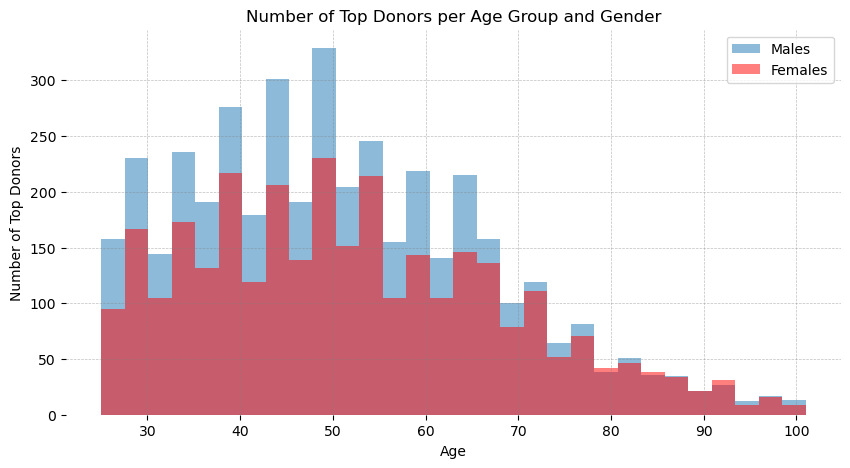

In [115]:
#Number of Donors per Age Group and Gender
fig, ax = plt.subplots(figsize=(10, 5))

# Filter the dataset for top donors
top_donor_data = donor_basetable[donor_basetable['top_donor'] == 1]

# Histogram for 'age_2020' with separate bars for males and females
ax.hist(top_donor_data.loc[top_donor_data['is_M'] == 1, 'age_2020'], bins=30, alpha=0.5, label='Males')
ax.hist(top_donor_data.loc[top_donor_data['is_F'] == 1, 'age_2020'], bins=30, alpha=0.5, label='Females', color='red')

ax.set_title('Number of Top Donors per Age Group and Gender')
ax.set_xlabel('Age')
ax.set_ylabel('Number of Top Donors')

plt.grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.legend()

plt.show()


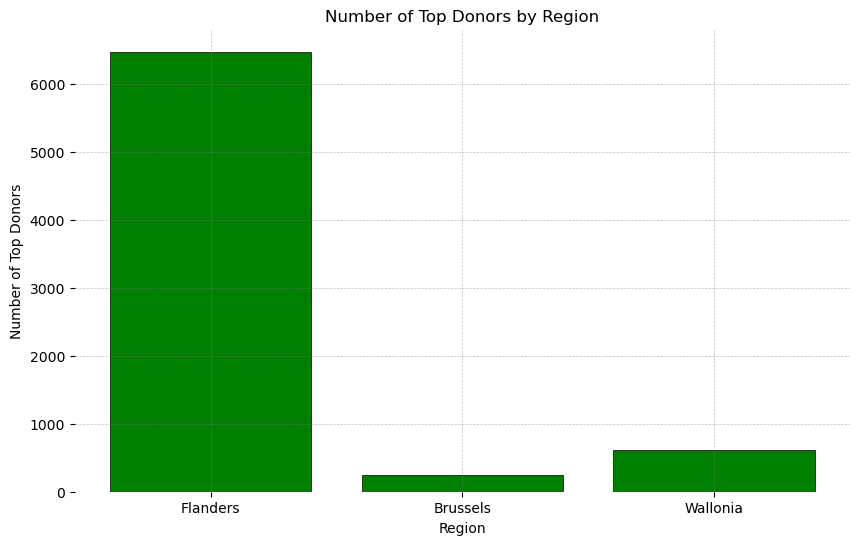

In [116]:
# Bar plot for the number of donors in each region
# Filter the DataFrame based on the condition top_donor == 1
selected_dataframe = donor_basetable[donor_basetable['top_donor'] == 1]

# Bar plot for the number of donors in each region for selected_dataframe
fig, ax = plt.subplots(figsize=(10, 6))

regions = ['Flanders', 'Brussels', 'Wallonia']

for region in regions:
    ax.bar(region, selected_dataframe[f'R_is_{region}'].sum(), color='green', edgecolor='black', linewidth=0.5)

ax.set_title("Number of Top Donors by Region")
ax.set_xlabel("Region")
ax.set_ylabel("Number of Top Donors")

plt.grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()


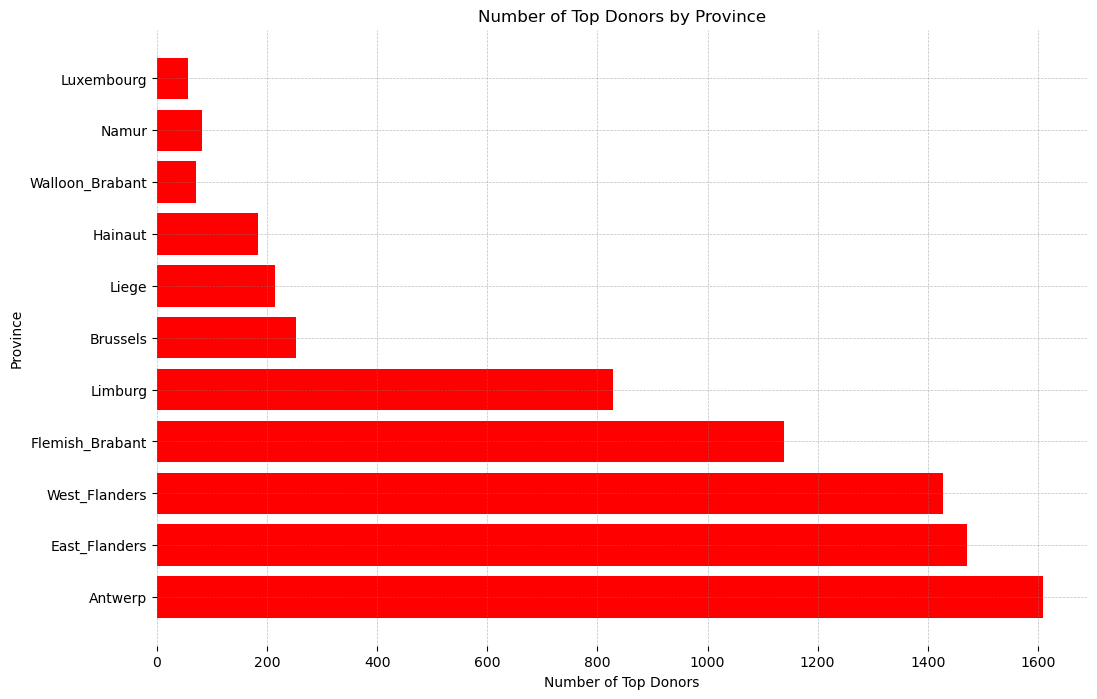

In [117]:
# Horizontal bar plot for the number of donors in each province

fig, ax = plt.subplots(figsize=(12, 8))

provinces = [
    'Antwerp', 'Brussels', 'East_Flanders', 'Flemish_Brabant', 'Hainaut',
    'Liege', 'Limburg', 'Luxembourg', 'Namur', 'Walloon_Brabant', 'West_Flanders'
]

# Sort provinces based on the number of donors
sorted_provinces = sorted(provinces, key=lambda province: donor_basetable[f'P_is_{province}'].sum(), reverse=True)

# Filter the data where top_donor is equal to 1
filtered_data = donor_basetable[donor_basetable['top_donor'] == 1]

bar_colors = ['red' for _ in sorted_provinces]

ax.barh(sorted_provinces, [filtered_data[f'P_is_{province}'].sum() for province in sorted_provinces], color=bar_colors)

ax.set_title("Number of Top Donors by Province")
ax.set_xlabel("Number of Top Donors")
ax.set_ylabel("Province")

plt.grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()



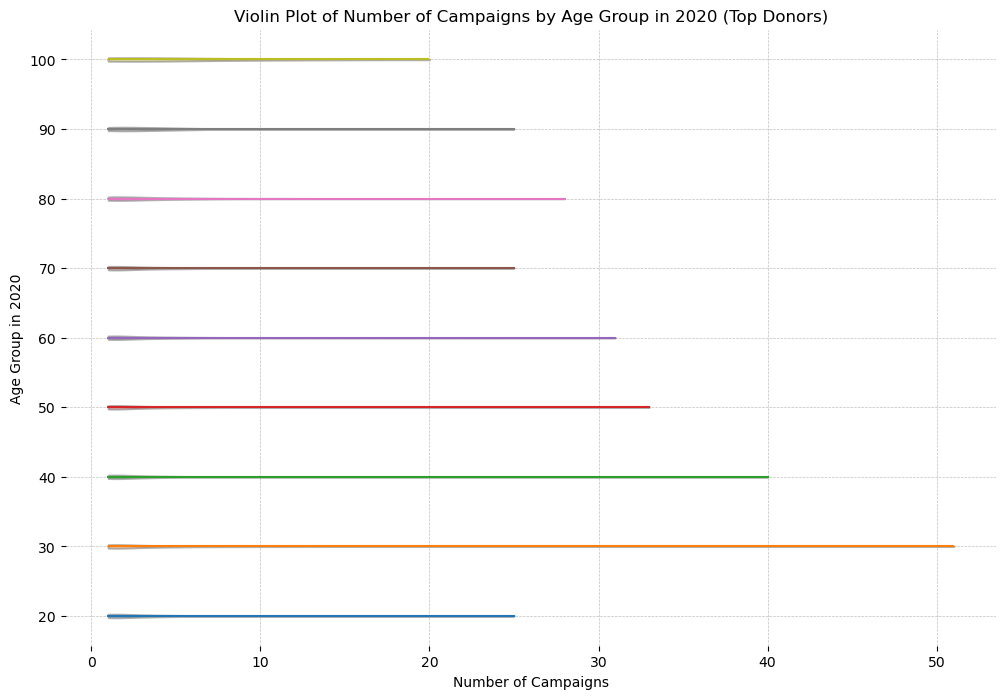

In [118]:
# Violin plot for 'nb_of_campaigns' by 'age_group_2020'
# Filter the data where 'top_donor' is equal to 1
top_donor_data = donor_basetable[donor_basetable['top_donor'] == 1]

# Create a violin plot for the number of campaigns by age group
fig, ax = plt.subplots(figsize=(12, 8))

# Use the filtered data for 'top_donor'
for age_group, data in top_donor_data.groupby('age_group_2020'):
    vp = ax.violinplot(data['nb_of_campaigns'], positions=[age_group], showmedians=True, vert=False)
    for pc in vp['bodies']:
        pc.set_edgecolor('black')
        pc.set_linewidth(1.5)

ax.set_title("Violin Plot of Number of Campaigns by Age Group in 2020 (Top Donors)")
ax.set_xlabel("Number of Campaigns")
ax.set_ylabel("Age Group in 2020")

plt.grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.show()


In [119]:
donor_basetable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26511 entries, 0 to 26510
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   donorID                  26511 non-null  int64  
 1   zipcode                  26511 non-null  int64  
 2   R_is_Flanders            26511 non-null  int32  
 3   R_is_Brussels            26511 non-null  int32  
 4   R_is_Wallonia            26511 non-null  int32  
 5   P_is_Antwerp             26511 non-null  int32  
 6   P_is_Brussels            26511 non-null  int32  
 7   P_is_East_Flanders       26511 non-null  int32  
 8   P_is_Flemish_Brabant     26511 non-null  int32  
 9   P_is_Hainaut             26511 non-null  int32  
 10  P_is_Liege               26511 non-null  int32  
 11  P_is_Limburg             26511 non-null  int32  
 12  P_is_Luxembourg          26511 non-null  int32  
 13  P_is_Namur               26511 non-null  int32  
 14  P_is_Walloon_Brabant  

In [120]:
selected_columns = ['donorID','top_donor', 'probability']
donor_basetable[selected_columns]

,donorID,top_donor,probability
0,100001,0,0.001106
1,100003,0,0.082654
2,100004,0,0.000171
3,100006,0,0.008748
4,100009,0,0.000346
...,...,...,...
26506,144687,0,0.000550
26507,144688,0,0.064110
26508,144689,0,0.003379
26509,144690,0,0.003442


In [121]:
selected_columns = ['donorID','top_donor', 'probability']
selected_dataframe = donor_basetable.loc[donor_basetable['top_donor'] == 1, selected_columns]
selected_dataframe

,donorID,top_donor,probability
7,100013,1,0.974450
9,100016,1,0.988205
10,100017,1,1.000000
12,100019,1,0.765355
13,100020,1,0.768939
...,...,...,...
26497,144668,1,0.907725
26498,144669,1,0.569686
26500,144675,1,0.629476
26502,144680,1,0.999457


In [122]:
selected_dataframe.describe()

,donorID,top_donor,probability
count,7334.000000,7334.0,7334.000000
mean,124378.488001,1.0,0.834520
std,13466.057644,0.0,0.156124
min,100013.000000,1.0,0.500144
25%,112102.750000,1.0,0.711612
50%,124157.500000,1.0,0.873042
75%,137670.500000,1.0,0.988026
max,144683.000000,1.0,1.000000


In [123]:
total_donors = 25645
most_likely_donors = 6996

percentage_most_likely_donors = (most_likely_donors / total_donors) * 100

print(f"Percentage of donors most likely to donate: {percentage_most_likely_donors:.2f}%")


Percentage of donors most likely to donate: 27.28%


In [124]:
total_donation_amount = 6996 * 30  # Assuming each person donates 30 (adjust this if you have a specific column for donation amounts)
number_of_donors = 6996

average_donation_amount = total_donation_amount / number_of_donors

print(f"Average Donation Amount among most likely donors: ${average_donation_amount:.2f}")


Average Donation Amount among most likely donors: $30.00
